In [12]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt 

# Ошибка
## Начинается всё с метода максимизации правдоподобия 
### На классах {0, 1}
$$Likehood = \prod \pi(x)^{y_i} \cdot (1 - \pi(x)^{(1 - y_i)}$$
$$\pi(x) = \frac{1}{1 + w^T \cdot x}$$
$$LogLikehood = \ln Likehood = \sum(y_i \log(\pi(x_i) + (1-y_i)\log(1-\pi(x_i))$$

### На классах {-1, 1}
$$Q = \sum \ln(1 + e^{-y_i <w, x>})$$

## Производная по w

$$\nabla_{w} Q = \sum \frac{1}{1 + exp{(-y_i<w, x_i>)}} \cdot exp{(-y_i<w, x_i>)} \cdot {-y_i * \vec{x_i}}$$

# GD
## SGD
Будем задавать `batch_size` как долю от всех строк матрицы, которые будут рандомно сэмплироваться.

При `batch_size`=1 получится градиентный спуск

## Проверим написанное
### Сузим ирисы до двух типов

In [13]:
import imp
import classiFIRE as FIRE
from sklearn.linear_model import LogisticRegression
imp.reload(FIRE)

clf_fire = FIRE.classiFIRE()

In [14]:
import sklearn.datasets as datasets
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

data = pd.DataFrame()
data['a'] = X[:, 1]
data['b'] = X[:, 0]
data['y'] = y
data = data[(data['y']==1) | (data['y'] == 0)]
data['y'] = data['y'].apply(lambda z: 1 if z == 1 else -1)

In [15]:
x = data[['a', 'b']].values
y = data['y'].values

Очень быстрый sklearn-овский класификатор

In [16]:
clf = LogisticRegression(random_state=134)
clf.fit(x, y)

LogisticRegression(random_state=134)

И мой

In [17]:
clf_fire = FIRE.classiFIRE()
clf_fire.fit(x, y, learning_rate=1e-3, tol=1e-3,batch_size=0.5)

In [18]:
answers = pd.DataFrame()
answers['fire'] = clf_fire.predict_proba(x)[: , 0]
answers['sklearn'] = clf.predict_proba(x)[: , 0]
answers

,fire,sklearn
0,0.947920,0.898624
1,0.725881,0.783599
2,0.930770,0.924625
3,0.916520,0.925019
4,0.976197,0.942247
...,...,...
95,0.187663,0.235738
96,0.122093,0.185670
97,0.029392,0.046631
98,0.102166,0.301539


Выставим threshold = 0.5 и классифицируем

In [19]:
def decode(x):
    out = []
    for z in x:
        if z > 0.5:
            out.append(1)
        else:
            out.append(-1)
    return out

In [20]:
answers = answers.apply(decode)
answers

,fire,sklearn
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
95,-1,-1
96,-1,-1
97,-1,-1
98,-1,-1


In [21]:
answers[answers['fire'] != answers['sklearn']]

,fire,sklearn
41,-1,1


Результаты непротиворечивы, а работает намоног омедленней. Исследуем время работы в зависимости от `batch_size`

In [22]:
sizes = np.linspace(0.1, 1, 50)
times = []
for _i, size in enumerate(sizes):
    print(f'{_i+1}/{len(sizes)}', end = '\r')
    start = time.time()
    clf_fire.fit(x, y, learning_rate=1e-3, tol=1e-3, batch_size=size)
    end = time.time()
    times.append(end - start)

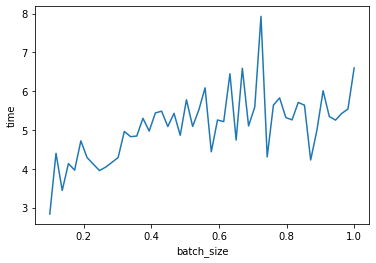

In [24]:
plt.plot(sizes, times)
plt.xlabel('batch_size')
plt.ylabel('time')
plt.show()